In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml.recommendation import ALS

from pyspark.sql.functions import lit
from pyspark.sql.functions import isnan, when, count, col

from pyspark.sql import SparkSession

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
training = pd.read_csv('data/training.csv')
movies = pd.read_csv('data/movies.dat', delimiter='::', names=['movie_id', 'movie_title', 'genre'], index_col='movie_id', engine='python')
users = pd.read_csv('data/users.dat', delimiter='::', names=['user_id', 'sex', 'age', 'occupation', 'zip_code' ], index_col='user_id', engine='python')

In [7]:
ratings_df = spark.createDataFrame(df)
ratings_df.show()

+----+-----+------+---------+
|user|movie|rating|timestamp|
+----+-----+------+---------+
|6040|  858|     4|956703932|
|6040|  593|     5|956703954|
|6040| 2384|     4|956703954|
|6040| 1961|     4|956703977|
|6040| 2019|     5|956703977|
|6040| 1419|     3|956704056|
|6040|  573|     4|956704056|
|6040| 3111|     5|956704056|
|6040|  213|     5|956704056|
|6040| 3505|     4|956704056|
|6040| 1734|     2|956704081|
|6040|  912|     5|956704191|
|6040|  919|     5|956704191|
|6040| 2503|     5|956704191|
|6040|  527|     5|956704219|
|6040|  318|     4|956704257|
|6040| 1252|     5|956704257|
|6040|  649|     5|956704257|
|6040| 3289|     5|956704305|
|6040|  759|     5|956704448|
+----+-----+------+---------+
only showing top 20 rows



In [48]:
# split based on timestamp, for roughly an 80-20 split
train_df = df[df['timestamp'] < 974740000]
test_df = df[df['timestamp'] >= 974740000]

In [49]:
train_df.shape[0] / df.shape[0]

0.80228

In [50]:
(train_df.shape[0] + test_df.shape[0]) / df.shape[0]

1.0

In [52]:
train = spark.createDataFrame(train_df)
test = spark.createDataFrame(test_df)

In [53]:
density = (train.count() / (train.select('user').distinct().count() * train.select('movie').distinct().count()))

print(f'Density of training data: {density * 100:.2f}%')

Density of training data: 3.99%


Max Ratings: 1440
Min Ratings: 2


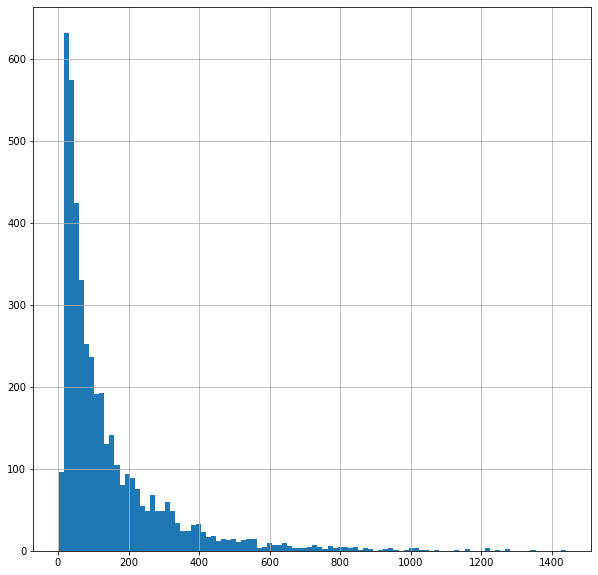

In [54]:
user_count = train.groupBy('user').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100, figsize=(10,10))

Max Ratings: 2328
Min Ratings: 1


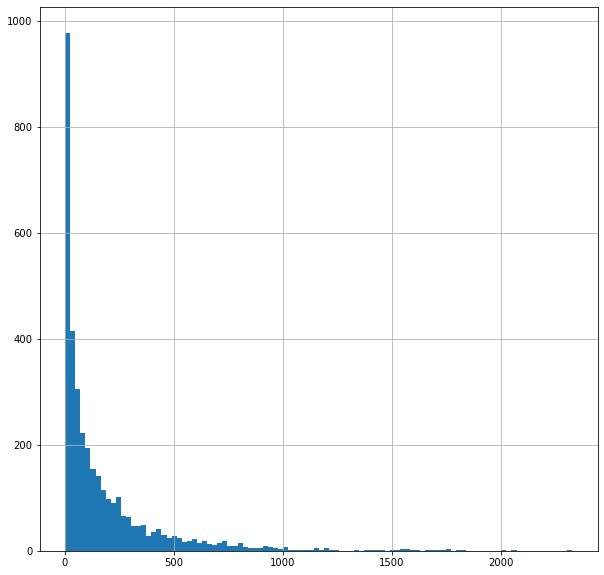

In [55]:
movie_count = train.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100, figsize=(10,10))

# Create an untrained ALS model.


In [56]:
als_model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10)

In [57]:
# Train the ALS model. We'll call the trained model `recommender`.
recommender = als_model.fit(train)

In [58]:
sorted(recommender.userFactors.collect())[:5]

[Row(id=1562, features=[0.5151082277297974, 0.7297458648681641, 0.9029687643051147, 0.16252802312374115, 0.08228518813848495, 0.747305691242218, 0.3390095829963684, 0.8523492217063904, 1.2764006853103638, 1.2317783832550049]),
 Row(id=1563, features=[1.490267276763916, 0.30610713362693787, 0.8475662469863892, 0.18378660082817078, 0.7832780480384827, 0.9630808234214783, 1.3082385063171387, 0.646838903427124, 0.39625564217567444, 0.6669080853462219]),
 Row(id=1564, features=[0.9157465696334839, 0.3780769407749176, 0.7880100607872009, 0.5875326991081238, 0.7683038115501404, 1.3594409227371216, 0.8434775471687317, 0.42871493101119995, 0.43357548117637634, 0.8848177194595337]),
 Row(id=1565, features=[0.9734428524971008, 0.0, 0.4443012773990631, 0.5882100462913513, 0.3691701889038086, 1.3335806131362915, 1.038760781288147, 0.7093330025672913, 0.772724449634552, 0.7995473742485046]),
 Row(id=1566, features=[0.7359766960144043, 0.0, 0.7002680897712708, 0.0, 1.68820321559906, 1.172582268714904

In [59]:
sorted(recommender.itemFactors.collect())[:5]

[Row(id=1, features=[0.9190021753311157, 0.27768293023109436, 0.7115711569786072, 0.24330514669418335, 0.37826618552207947, 0.637026846408844, 0.3018113076686859, 0.12141098082065582, 0.5271127820014954, 0.8423641920089722]),
 Row(id=2, features=[0.4688868820667267, 0.2095651477575302, 0.5876148343086243, 0.29976698756217957, 0.12336818873882294, 0.6235687136650085, 0.2116233855485916, 0.29904985427856445, 0.7781823873519897, 0.29810526967048645]),
 Row(id=3, features=[0.4900987446308136, 0.33635079860687256, 0.0, 0.20082417130470276, 0.0, 0.8087934851646423, 0.0, 0.4998330771923065, 0.7523779273033142, 0.49536553025245667]),
 Row(id=4, features=[0.605455756187439, 0.5693897008895874, 0.2265513688325882, 0.08744049072265625, 0.2711157500743866, 0.46212753653526306, 0.22150182723999023, 0.027150044217705727, 0.8465858697891235, 0.03906070441007614]),
 Row(id=5, features=[0.4743422567844391, 0.5139743685722351, 0.0800316259264946, 0.0, 0.00015428016195073724, 0.6715837121009827, 0.002027

In [60]:
yhat_train = recommender.transform(train)

In [61]:
yhat_train.select([count(when(isnan(c), c)).alias(c) for c in yhat_train.columns]).show()

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|prediction|
+----+-----+------+---------+----------+
|   0|    0|     0|        0|         0|
+----+-----+------+---------+----------+



In [62]:
yhat_train.show()

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|prediction|
+----+-----+------+---------+----------+
|4227|  148|     2|965659724| 2.1379628|
|3184|  148|     4|968708953| 3.2579472|
|4784|  148|     3|970000570| 2.9012449|
|2383|  148|     2|974417654| 2.3509796|
|3539|  148|     3|966932408| 2.7074847|
|3829|  148|     2|965940170| 2.3784328|
|2456|  148|     2|974178993| 2.4450996|
|2507|  148|     4|974082717| 3.1364677|
|3053|  148|     3|970170090|  2.677186|
|3841|  463|     3|966003085|  2.566588|
|3650|  463|     2|966459084|  2.589714|
|3151|  463|     5|968916009| 3.9177732|
|4858|  463|     3|963746396| 2.4707265|
|2629|  463|     4|973625620| 3.1455767|
|3328|  463|     4|967918151| 3.1497078|
|4040|  463|     1|965505136| 1.7982821|
|4277|  463|     4|965469038| 3.3358335|
|2051|  463|     1|974663178| 1.9354658|
|3753|  463|     2|966184754| 2.2116852|
|5047|  463|     3|966134684| 2.2635717|
+----+-----+------+---------+----------+
only showing top

In [63]:
predictions = recommender.transform(test)

In [64]:
# nans in the testing prediction
predictions.select([count(when(isnan(c), c)).alias(c) for c in yhat_train.columns]).show()

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|prediction|
+----+-----+------+---------+----------+
|   0|    0|     0|        0|    126058|
+----+-----+------+---------+----------+



# Evaluate baseline

In [65]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [66]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [67]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [68]:
predictions_df.head()

,user,movie,rating,timestamp,prediction,squared_error
0,673,148,5,975620824,3.606881,1.940779
1,1242,148,3,974909976,3.606881,0.368305
2,1069,148,2,974945135,3.606881,2.582068
3,1605,148,2,974930221,1.980308,0.000388
4,1150,148,2,974875106,3.606881,2.582068


In [69]:
predictions_df.describe()

,user,movie,rating,timestamp,prediction,squared_error
count,158176.000000,158176.000000,158176.000000,1.581760e+05,158176.000000,1.581760e+05
mean,1280.579235,1868.670829,3.523923,9.750753e+08,3.545189,1.235456e+00
std,516.866310,1103.873411,1.146110,3.016431e+05,0.329173,1.646257e+00
min,636.000000,1.000000,1.000000,9.747400e+08,0.290563,4.604317e-10
25%,935.000000,1025.000000,3.000000,9.748185e+08,3.606881,1.545423e-01
50%,1202.000000,1836.000000,4.000000,9.749512e+08,3.606881,3.683050e-01
75%,1491.000000,2770.000000,4.000000,9.753519e+08,3.606881,1.940779e+00
max,5996.000000,3952.000000,5.000000,9.757673e+08,5.577134,1.247443e+01


In [74]:
avg_sq_err = predictions_df.describe()['squared_error']['mean']
print(f'Average squared error of predictions: {avg_sq_err:.2f}')

Average squared error of predictions: 1.24


In [76]:
# Calculate RMSE
rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
print(f'Root Mean Squared Error of Predictions: {rmse:.2f}')

Root Mean Squared Error of Predictions: 1.11


In [83]:
std_rating = predictions_df.describe()['rating']['std']
std_pred = predictions_df.describe()['prediction']['std']

print(f'Standard Deviation of Rating: {std_rating:.2f}')
print(f'Standard Deviation of Prediction: {std_pred:.2f}')

Standard Deviation of Rating: 1.15
Standard Deviation of Prediction: 0.33


In [84]:
_mean = predictions_df['rating'].mean()
rmsep = rmse / _mean
print(f'RMSE Percentage = {rmsep * 100:.2f}%')

RMSE Percentage = 31.54%


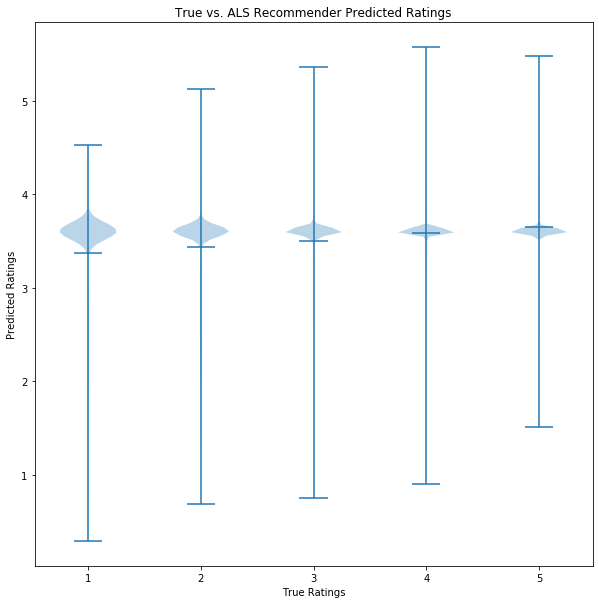

In [82]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
fig, ax = plt.subplots(figsize=(10,10))
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

# implicit interactions

In [39]:
train = train.withColumn("imp_rating", lit(1))


In [40]:
train.show()

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|imp_rating|
+----+-----+------+---------+----------+
|5344|  300|     4|960670929|         1|
|5344|  480|     3|960670865|         1|
|5344| 1210|     1|960671010|         1|
|5344| 2330|     4|960671323|         1|
|5344| 3671|     4|960671113|         1|
|5344| 3688|     1|960671208|         1|
|5344| 3724|     4|960671133|         1|
|5345|    6|     5|960671329|         1|
|5345|   21|     3|960671248|         1|
|5345|  110|     5|960671248|         1|
|5345|  172|     3|960670788|         1|
|5345|  260|     5|960671126|         1|
|5345|  306|     4|960671025|         1|
|5345|  381|     5|960671025|         1|
|5345|  457|     4|960671248|         1|
|5345|  474|     4|960671329|         1|
|5345|  858|     5|960671126|         1|
|5345| 1036|     4|960671279|         1|
|5345| 1196|     5|960670761|         1|
|5345| 1197|     5|960671216|         1|
+----+-----+------+---------+----------+
only showing top

In [41]:
als_model_imp = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train)

In [42]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()